In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from pysimu import ode2numba, ssa

from ipywidgets import *


In [2]:
%matplotlib notebook

## System definition 

In [3]:
sys = { 't_end':20.0,'Dt':0.01,'solver':'forward-euler', 'decimation':10, 'name':'smib_2nd',
   'models':[{'params':
                   {'X_d' : 1.81,
                    'X1d'  : 0.3,
                    'T1d0'  : 8.0,
                    'X_q'  : 1.76,
                    'X1q'  : 0.65,
                    'T1q0'  : 1.0 ,
                    'R_a'  :  0.003, 
                    'X_l'  : 0.15 , 
                    'H'  : 3.5,   
                    'Omega_b' : 2*np.pi*60,
                    'B_t0':0.0,
                    'G_t_inf':0.0,
                    'T_r' : 0.05,
                    'theta_inf': 0.0,  
                    'T_r':0.05,  
                    'T_pss_1' : 1.281,
                    'T_pss_2' : 0.013,
                    'T_w' : 5.0,
                    'D':1.0,
                    'K_a':200.0,
                    'K_stab':10,
                    'B_t_inf':-1.0/(0.15+1.0/(1.0/0.5+1.0/0.93)),
                    'G_t0':0.01,
                    'V_inf':0.9008,
                    'e1q':1.1,
                    'e1d':0.0},
              'f':[
                    'ddelta=Omega_b*(omega - 1)',
                    'domega = -(p_e - p_m + D*(omega - 1))/(2*H)',
                   ],
              'g':[  'i_d@ v_q - e1q + R_a*i_q + i_d*(X1d - X_l)',
                     'i_q@ v_d - e1d + R_a*i_d - i_q*(X1q - X_l)',
                     'p_e@ p_e - i_d*(v_d + R_a*i_d) - i_q*(v_q + R_a*i_q) ',
                     'v_d@ v_d - V_t*sin(delta - theta_t)',
                     'v_q@ v_q - V_t*cos(delta - theta_t)',
                     'P_t@ i_d*v_d + i_q*v_q - P_t',
                     'Q_t@ i_d*v_q - i_q*v_d - Q_t ',
                     'theta_t @(G_t0 + G_t_inf)*V_t**2 - V_inf*(G_t_inf*cos(theta_t - theta_inf) + B_t_inf*sin(theta_t - theta_inf))*V_t - P_t',
                     'V_t@ (- B_t0 - B_t_inf)*V_t**2 + V_inf*(B_t_inf*cos(theta_t - theta_inf) - G_t_inf*sin(theta_t - theta_inf))*V_t - Q_t',
                      ],
              'u':{'p_m':0.9,'V_ref':1.0}, 
              'u_ini':{},
              'y_ini':[  'i_d',  'i_q',  'p_e',  'v_d', 'v_q', 'P_t', 'Q_t', 'theta_t','V_t'],
              'h':[
                   'omega'
                   ]}
              ],
    'perturbations':[{'type':'step','time':1.0,'var':'V_ref','final':1.01} ]
    }

x,f = ode2numba.system(sys)  

Matrix([[i_d], [i_q], [p_e], [v_d], [v_q], [P_t], [Q_t], [theta_t], [V_t]])
N_y 9
 v_q - e1q + R_a*i_q + i_d*(X1d - X_l),  v_d - e1d + R_a*i_d - i_q*(X1q - X_l),  p_e - i_d*(v_d + R_a*i_d) - i_q*(v_q + R_a*i_q) ,  v_d - V_t*sym.sin(delta - theta_t),  v_q - V_t*sym.cos(delta - theta_t),  i_d*v_d - P_t + i_q*v_q,  i_d*v_q - Q_t - i_q*v_d, (G_t0 + G_t_inf)*V_t**2 - V_inf*(G_t_inf*sym.cos(theta_t - theta_inf) + B_t_inf*sym.sin(theta_t - theta_inf))*V_t - P_t,  (- B_t0 - B_t_inf)*V_t**2 + V_inf*(B_t_inf*sym.cos(theta_t - theta_inf) - G_t_inf*sym.sin(theta_t - theta_inf))*V_t - Q_t, 


In [4]:
import smib_2nd

In [5]:
syst = smib_2nd.smib_2nd_class()
x0 = np.ones(syst.N_x+syst.N_y)
s = sopt.fsolve(syst.run_problem,x0 )
print(s)

[0.78780299 1.         0.74242941 0.66183756 0.9        0.32869149
 0.98665008 0.89703231 0.51497766 0.46622746 1.03995984]


<IPython.core.display.Javascript object>


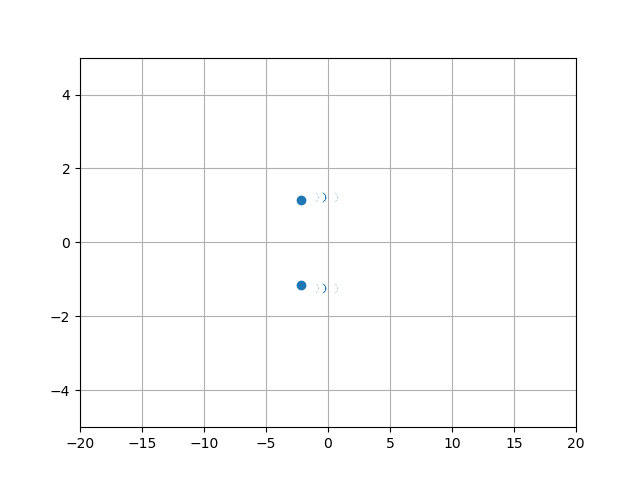

In [6]:
fig,axes = plt.subplots(nrows=1)
points = axes.plot([],[],'o')
axes.set_xlim(-20,20)
axes.set_ylim(-5,5)
axes.grid(True)
def Jac(x):
  
    J=np.vstack((np.hstack((syst.struct[0].Fx,syst.struct[0].Fy)),np.hstack((syst.struct[0].Gx,syst.struct[0].Gy))))
    return J

def update(p_m = 0.9, D=10):
    syst.struct[0].p_m = p_m
    syst.struct[0].D = D
    x0 = np.vstack([syst.struct[0].x, syst.struct[0].y])
    x0 = np.ones(syst.N_x+syst.N_y)
    #x0[0,0] = 0.0

    frime = np.vstack((syst.struct[0].f,syst.struct[0].g))
    s = sopt.fsolve(syst.run_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:(syst.N_x+syst.N_y)]
    #print(np.linalg.det(syst.struct[0].Gy))
    e,v = np.linalg.eig(ssa.eval_A(syst))
    points[0].set_xdata(e.real)
    points[0].set_ydata(e.imag/np.pi/2)
    delta = np.rad2deg(syst.struct[0].x[0,0])
    print(delta)
    fig.canvas.draw()

In [7]:
interact(update);

interactive(children=(FloatSlider(value=0.9, description='p_m', max=2.7, min=-0.9), IntSlider(value=10, descri…